<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/06_Transformers/NLP-With-Transformers/02-NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiingual Name Entity Recognition



In [1]:
!pip install -q transformers accelerate datasets \
  seqeval mlxtend watermark rich

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,transformers --conda

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
polars      : 0.20.2
mlxtend     : 0.23.1
transformers: 4.42.4

conda environment: n/a



In [3]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# # Black code formatter (Optional)
# %load_ext lab_black

# # auto reload imports
# %load_ext autoreload
# %autoreload 2

In [4]:
from datasets import Dataset, get_dataset_config_names, load_dataset


xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [5]:
# Select the config that starts with `PAN`
pan_subsets: list[str] = [s for s in xtreme_subsets if s.startswith("PAN")]
print(pan_subsets[:3])

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']


In [6]:
from datasets import DatasetDict


# Load English subset
en_dataset: DatasetDict = load_dataset("xtreme", name="PAN-X.en")
en_dataset

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
# Shuffle
en_dataset['train'].shuffle(seed=123)

# Select a specific number of records
print(en_dataset['train'].select(range(10)))

# Check the number pf records
print(f"Number of records: {len(en_dataset['train']):,}")

# OR
print(f"Number of records: {en_dataset['train'].num_rows:,}")

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 10
})
Number of records: 20,000
Number of records: 20,000


#### Coment

- To create a realistic Swiss corpus, we'll sample PAN-X corpora in German (62.9%), French (22.9%), Italian (8.4%), and English (5.9%) according to their spoken proportions in Switzerland.
- This will create a language imbalance simulating real-world datasets.
- We'll use a Python `defaultdict` to store language codes and corresponding PAN-X corpora.

In [8]:
from collections import defaultdict


seed: int = 123
langs: list[str] = ["de", "fr", "it", "en"]
fracs: list[float] = [0.629, 0.229, 0.084, 0.059]
panx_ch: defaultdict = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load dataset
    ds: DatasetDict = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
      num_rows: int = ds[split].num_rows
      panx_ch[lang][split] = ds[split].shuffle(seed=seed).select(range(int(frac * num_rows)))


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }),
             'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'la

In [10]:
for key, val in panx_ch.items():
  print(val)
  break

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
})


In [11]:
# Number of training examples per language
res: dict[str, int] = {key:val["train"].num_rows for key, val in panx_ch.items()}
pl.DataFrame(res)


de,fr,it,en
i64,i64,i64,i64
12580,4580,1680,1180


In [12]:
# Inspect one of the languages
sample = panx_ch["en"]["train"][0]
sample

{'tokens': ['Collin', 'Peterson', '(', 'D-MN', ')'],
 'ner_tags': [1, 2, 0, 0, 0],
 'langs': ['en', 'en', 'en', 'en', 'en']}

In [13]:
print(panx_ch["en"]["train"].features)

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}


In [14]:
ner_tags = panx_ch["en"]["train"].features["ner_tags"]
tags = ner_tags.feature
print(f"{ner_tags = }")
print(f"{tags = }")

ner_tags = Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
tags = ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [15]:
for idx, _ in enumerate(tags.names):
  console.print(f"{idx} ==> {tags.int2str(idx)}")

0 ==> O

1 ==> B-PER

2 ==> I-PER

3 ==> B-ORG

4 ==> I-ORG

5 ==> B-LOC

6 ==> I-LOC

In [16]:
pprint(panx_ch["en"]["train"][10])

{'langs': ['en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en',
           'en'],
 'ner_tags': [0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2],
 'tokens': ['Tries',
            ':',
            'Todd',
            'Carney',
            ',',
            'Ricky',
            'Leutele',
            ',',
            'Michael',
            'Gordon',
            ',',
            'Jeff',
            'Robson']}


In [17]:
def create_tag_names(batch: DatasetDict) -> dict[str, Any]:
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}


panx_de: DatasetDict = panx_ch["de"].map(create_tag_names)

panx_de["train"][5]

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

{'tokens': ['Die',
  'meisten',
  'seiner',
  'Gemälde',
  'sind',
  'im',
  'Statens',
  'Museum',
  'for',
  'Kunst',
  'zu',
  'sehen',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'I-ORG',
  'I-ORG',
  'I-ORG',
  'O',
  'O',
  'O']}

In [18]:
pl.DataFrame(panx_de["train"].select_columns(['tokens', 'ner_tags_str'])[5]).transpose()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12
str,str,str,str,str,str,str,str,str,str,str,str,str
"""Die""","""meisten""","""seiner""","""Gemälde""","""sind""","""im""","""Statens""","""Museum""","""for""","""Kunst""","""zu""","""sehen""","""."""
"""O""","""O""","""O""","""O""","""O""","""O""","""B-ORG""","""I-ORG""","""I-ORG""","""I-ORG""","""O""","""O""","""O"""


In [19]:
# Check the distribution of all the tags
from collections import Counter


splits_freq = defaultdict(Counter)

for split, ds in panx_de.items():
  for row in ds["ner_tags_str"]:
    for tag in row:
      # Focus on the `beginning` tags
      if tag.startswith("B"):
        tag_type: str = tag.split("-")[1]
        splits_freq[split][tag_type] += 1

In [20]:
# The tags are roughly equally distributed
console.print(f"{splits_freq = }")

pl.DataFrame(splits_freq).to_pandas()

splits_freq = defaultdict(<class 'collections.Counter'>, {'train': Counter({'LOC': 6039, 'PER': 5862, 'ORG': 
5413}), 'validation': Counter({'LOC': 3095, 'PER': 2837, 'ORG': 2721}), 'test': Counter({'LOC': 3145, 'PER': 2962, 
'ORG': 2620})})

,train,validation,test
0,"{'PER': 5862, 'LOC': 6039, 'ORG': 5413}","{'PER': 2837, 'LOC': 3095, 'ORG': 2721}","{'ORG': 2620, 'PER': 2962, 'LOC': 3145}"


<br>

## Multilingual Transformers

- Multilingual transformers are trained on multilingual corpora and they can generalize well across languages for various tasks.

- This approach can outperform monolingual models for cross-lingual transfer, avoiding the need to train separate models for each language.

- `CoNLL-2002` and `CoNLL-2003` are commonly used benchmarks for NER in these languages.

- Multilingual transformer models are usually evaluated in three different ways:
  - `en`: Fine-tune on the English training data and then evaluate on each language's test set.
  - `each`: Fine-tune and evaluate on monolingual test data to measure per-language performance.
  - `all`: Fine-tune on all the training data to evaluate on all on each languag's test set.

  <br>

- [XLM-RoBERTa (`XLM-R`)](https://huggingface.co/docs/transformers/en/model_doc/xlm-roberta) model will be used.

- XLM-RoBERTa (XLM-R) is a multilingual transformer model trained on a massive dataset of text and code in 100 different languages.
  
- It can be used for a variety of tasks, including:

  - Text classification: Sentiment analysis, topic classification, etc.
  - Question answering: Extracting answers to questions from a given text.
  - Translation: Translating text from one language to another.
  - Named entity recognition: Identifying named entities in text, such as people, organizations, and locations.

- XLM-R achieves state-of-the-art results on many cross-lingual benchmarks, and it is a powerful tool for natural language processing in multiple languages.

#### Tokenization: SentencePiece



In [21]:
from transformers import AutoTokenizer


bert_model_name: str = "bert-base-cased"
xlmr_model_name: str = "xlm-roberta-base"

bert_tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [22]:
text: str = "Jack Sparrow loves New York!"

bert_tokens: list[str] = bert_tokenizer(text).tokens()
xlmr_tokens: list[str] = xlmr_tokenizer(text).tokens()

print(f"{bert_tokens = }")
print(f"{xlmr_tokens = }")

bert_tokens = ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
xlmr_tokens = ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


### Tokenization Pipeline

<br>

[![image.png](https://i.postimg.cc/zvJ0SrZz/image.png)](https://postimg.cc/dkx2wgVp)

<br>

- `Normalization`: it involves cleaning raw text by removing whitespace, accents, and standardizing Unicode characters. It also includes lowercasing to reduce vocabulary size. After normalization, our example string becomes "jack sparrow loves new york!".

- `Pretokenization`: it splits text into words for easier tokenization. For English and similar languages, this is simple. For languages like Chinese, it's more complex and might require language-specific libraries.

- `Tokenizer model`: it splits words into subwords to reduce vocabulary size and out-of-vocabulary tokens. This is done using algorithms like BPE, Unigram, and WordPiece. For example, "jack sparrow" might become "[jack, spa, rrow]".

- `Postprocessing`: it's the final step in tokenization, where additional tokens (like [CLS] and [SEP]) are added to the beginning and end of the token sequence to prepare it for input into a model like BERT.


<hr><br>

#### SentencePiece Tokenizer

- The SentencePiece tokenizer is a flexible subword segmentation method that handles multilingual text effectively by preserving whitespace and using Unicode characters.

- It avoids ambiguities in detokenization and can be used for various languages without relying on language-specific pretokenizers.

### Transformers For Classification Vs NER

**1.) Classification**

[![image.png](https://i.postimg.cc/Mph53R2r/image.png)](https://postimg.cc/tsNFYsgh)

<br>

**2.) Named Entity Recognition**

[![image.png](https://i.postimg.cc/26YwrD5Q/image.png)](https://postimg.cc/rdhWN7xs)

<br>

- In `token classification`, assign the label (e.g., B-PER) to the first subword ("Chr") and ignore subsequent subwords ("##ista"). This convention follows the BERT paper and maintains the IOB2 format. Postprocessing can propagate the label to all subwords.


### Anatomy Transformers Model Class

- The Transformers API organizes models by task, but this can be limiting.
- If a desired task model doesn't exist, it can be difficult to implement a custom model.
- However, Transformers provides tools to load pretrained weights and use task-specific helper functions, making it easier to create custom models.

### Bodies And Heads

- Transformers are versatile due to their `body-head` structure.
- The `head` is task-specific, while the `body` is task-agnostic.
- The body includes embeddings and transformer layers. The Transformers code reflects this structure with classes like BertModel and GPT2Model that return hidden states.
- Task-specific models such as `BertForMaskedLM` or `BertForSequenceClassification` use the base model and add the necessary head on top of the hidden states.


<hr><br>

### Creating Custom Model For Token Classification

- Building a custom token classification head for XLM-R is similar to RoBERTa and an existing class, XLMRobertaForTokenClassification, can be used directly for this task.
- However, going through the exercise of building a custom model for educational purposes.

- We need a data structure for our XLM-R NER tagger.
- It will have a configuration object and a forward function.

In [23]:
from torch import Tensor
import torch.nn as nn
from transformers import XLMRobertaConfig, XLMRobertaModel
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    class_config = XLMRobertaConfig

    def __init__(self, config) -> None:
        super().__init__(config)
        self.num_labels = config.num_labels

        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)

        # Setup classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Load and initialize weights
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # Get the encoder representations using model body
        outputs: Tensor = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )

        # Apply classifier to encoder reps
        sequence_output: Tensor = self.dropout(outputs[0])
        logits: Tensor = self.classifier(sequence_output)

        # Calculate losses
        loss: Optional[Tensor] = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # Return model output object
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

#### Comment

- The config_class ensures standard XLM-R settings.
- The `super()` method calls the initialization function of the RobertaPreTrainedModel class.
- The model body is extended with a classification head.
- The `forward()` method defines the model's behavior.
- The hidden state is fed through the dropout and classification layers.
- The loss is calculated if labels are provided.
- The outputs are wrapped in a `TokenClassifierOutput` object.
- This custom transformer model inherits from a `PreTrainedModel`, allowing access to useful Transformer utilities.

<br>

### Loading A Custom Model


In [24]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [25]:
from transformers import AutoConfig


index2tag: dict[int, str] = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index: dict[str, int] = {tag: idx for idx, tag in enumerate(tags.names)}

xlmr_config: XLMRobertaConfig = AutoConfig.from_pretrained(
    xlmr_model_name, num_labels=len(tags.names), id2label=index2tag,
    label2id=tag2index
)
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [26]:
import torch


device: str = "cuda" if torch.cuda.is_available() else "cpu"
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name, config=xlmr_config
).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
text

'Jack Sparrow loves New York!'

In [28]:
# Check that the tokenizer and model were properly initialized
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
data: dict[str, int] = {
    col: int(val) for col, val in zip(xlmr_tokens, input_ids.flatten())
}
print(data)

pl.DataFrame(data)

{'<s>': 0, '▁Jack': 21763, '▁Spar': 37456, 'row': 15555, '▁love': 5161, 's': 7, '▁New': 2356, '▁York': 5753, '!': 38, '</s>': 2}


<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,21763,37456,15555,5161,7,2356,5753,38,2


In [29]:
# Pass the input to the model and extract the predictions
outputs = xlmr_model(input_ids.to(device)).logits
predictions: Tensor = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")

# (batch_size, num_tokens, num_tags)
print(f"Shape of outputs: {outputs.shape}")

# (batch_size, num_tokens)
print(f"Shape of predictions: {predictions.shape}")

print(f"{predictions = }")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])
Shape of predictions: torch.Size([1, 10])
predictions = tensor([[1, 0, 1, 0, 2, 0, 2, 1, 1, 1]], device='cuda:0')


In [30]:
data: dict[str, str] = {
    col: tags.names[p] for col, p in zip(xlmr_tokens, predictions.flatten())
}
print(data)

pl.DataFrame(data)

{'<s>': 'B-PER', '▁Jack': 'O', '▁Spar': 'B-PER', 'row': 'O', '▁love': 'I-PER', 's': 'O', '▁New': 'I-PER', '▁York': 'B-PER', '!': 'B-PER', '</s>': 'B-PER'}


<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
str,str,str,str,str,str,str,str,str,str
"""B-PER""","""O""","""B-PER""","""O""","""I-PER""","""O""","""I-PER""","""B-PER""","""B-PER""","""B-PER"""


In [31]:
def tag_text(
    text: str,
    tags: list[str],
    model: RobertaModel,
    tokenizer: AutoTokenizer,
) -> pl.DataFrame:
    # Get tokens with special characters
    tokens: list[str] = tokenizer(text).tokens()

    # Encode
    input_ids: Tensor = tokenizer(text, return_tensors="pt").input_ids.to(device)

    # Get predictions
    outputs: Tensor = model(input_ids).logits

    # Get predictions
    predictions: Tensor = torch.argmax(outputs, dim=-1)

    data: dict[str, str] = {
        col: tags.names[p]
        for col, p in zip(tokens, predictions.flatten().cpu().numpy())
    }

    return pl.DataFrame(data)

<br>

### Tokenizing Texts For NER

- To prepare the dataset for fine-tuning with XLM-R, we need to tokenize it. - Datasets provides a `map()` function for this.

- We need to define a function with the signature:
```py
function(examples: Dict[str, List]) -> Dict[str, List] to process the dataset.
```

- The XLM-R tokenizer's output returns input IDs for the model.
- To use the model, we need to add an attention mask and label IDs that indicate which tokens correspond to each NER tag.
- These can be obtained from the dataset's examples.

In [32]:
sample

{'tokens': ['Collin', 'Peterson', '(', 'D-MN', ')'],
 'ner_tags': [1, 2, 0, 0, 0],
 'langs': ['en', 'en', 'en', 'en', 'en']}

In [33]:
words, labels = sample["tokens"], sample["ner_tags"]

# Tokenize each word and specify that the input sequence has already been split into words.
tokenized_input = xlmr_tokenizer(
    words, is_split_into_words=True
)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pl.DataFrame(tokens).transpose()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str
"""<s>""","""▁Colli""","""n""","""▁Peter""","""son""","""▁(""","""▁D""","""-""","""MN""","""▁)""","""</s>"""


#### Comment

- The word `Collin` was split into `Colli` and `n` by the `SentencePience` tokenizer.
- Since we want to follow the convection that only `Colli` should be associated with the `B-PER` label,  we need a way to mask the subword representations after the subword.
- This can be done using `.word_ids()` method.
- `word_ids` has mapped each subword to the corresponding index in the words sequence, so the first subword, “__Colli", is assigned the index 0, while
“▁Peter” and “son” are assigned the index 1 (since “Peterson” is the second
word in words).
- We can also see that special tokens like `<s>` and `<\s>` are mapped to
None.
- Let's set `-100` as the label for these special tokens and the subwords we wish to mask during training.

In [34]:
word_ids = tokenized_input.word_ids()
data: dict[str, int] = {
    col: idx_ for col, idx_ in zip(tokens, word_ids)
}

pl.DataFrame(data)

<s>,▁Colli,n,▁Peter,son,▁(,▁D,-,MN,▁),</s>
null,i64,i64,i64,i64,i64,i64,i64,i64,i64,null
null,0,0,1,1,2,3,3,3,4,null


In [35]:
word_ids, labels

([None, 0, 0, 1, 1, 2, 3, 3, 3, 4, None], [1, 2, 0, 0, 0])

In [36]:
prev_word_idx: int | None = None
label_ids: list[int] = []

for word_idx in word_ids:
  if word_idx is None or word_idx == prev_word_idx:
    label_ids.append(-100)
  else:
    label_ids.append(labels[word_idx])
  prev_word_idx = word_idx


# Update the labels
labels = [index2tag[l] if l != -100 else "UKN" for l in label_ids]
index = ["Tokens", "Word IDs", "label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10
Tokens,<s>,▁Colli,n,▁Peter,son,▁(,▁D,-,MN,▁),</s>
Word IDs,None,0,0,1,1,2,3,3,3,4,None
label IDs,-100,1,-100,2,-100,0,0,-100,-100,0,-100
Labels,UKN,B-PER,UKN,I-PER,UKN,O,O,UKN,UKN,O,UKN


#### Comment

- The ID `-100` is used to mask subword representations in PyTorch's cross-entropy loss to ignore them during training, preventing their influence on the model's learning.

In [37]:
# Putting it together

def tokenize_and_align_labels(examples: dict[str, list]) -> dict[str, list]:
    """
    Tokenize and align labels for named entity recognition.

    Parameters
    ----------
    examples : dict[str, list]
        A dictionary containing 'tokens' and 'ner_tags' as keys.
        'tokens' : list of str
            List of words in the input sequence.
        'ner_tags' : list of int
            List of corresponding NER tags for each word.

    Returns
    -------
    dict[str, list]
        A dictionary containing tokenized inputs and aligned labels.
        'input_ids' : list of int
            Tokenized input sequence.
        'attention_mask' : list of int
            Attention mask for the tokenized sequence.
        'labels' : list of int
            Aligned labels for the tokenized sequence.

    Notes
    -----
    This function assumes the existence of a tokenizer named 'xlmr_tokenizer'.
    """
    labels: list[list[int]] = []

    # Tokenize each word and specify that the input sequence has
    # already been split into words.
    tokenized_inputs: dict[str, list] = xlmr_tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    for idx, label in enumerate(examples["ner_tags"]):
        word_ids: list[int | None] = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx: int | None = None
        label_ids: list[int] = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)

    # Add the labels to the inputs
    tokenized_inputs["labels"] = labels

    return tokenized_inputs



def encode_panx_dataset(corpus: DatasetDict) -> DatasetDict:
    """
    Encode the PAN-X dataset by applying tokenization and label alignment.
    Parameters
    ----------
    corpus : DatasetDict
        The input corpus to be encoded.
    Returns
    -------
    DatasetDict
        The encoded dataset with tokenized inputs and aligned labels.
    Notes
    -----
    This function uses the `tokenize_and_align_labels` function to process
    the dataset. It removes the original 'tokens', 'ner_tags', and 'langs'
    columns from the dataset.
    """
    encoded_corpus = DatasetDict()
    for split, dataset in corpus.items():
        encoded_corpus[split] = dataset.map(
            tokenize_and_align_labels,
            batched=True,
            remove_columns=["tokens", "ner_tags", "langs"],
            desc=f"Running tokenizer on {split} split",
        )
    return encoded_corpus

In [38]:
# Apply it to the entire dataset
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Running tokenizer on train split:   0%|          | 0/12580 [00:00<?, ? examples/s]

Running tokenizer on validation split:   0%|          | 0/6290 [00:00<?, ? examples/s]

Running tokenizer on test split:   0%|          | 0/6290 [00:00<?, ? examples/s]

<br>

### Performance Metrics

- Evaluating NER models involves precision, recall, and F1-score.
- All words of an entity must be predicted correctly.
- The `seqeval` library can compute these metrics using the `classification_report()` function.

In [39]:
from seqeval.metrics import classification_report


# Example usage
y_true: list[list[str]] = [
    ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O"],
]
y_pred: list[list[str]] = [
    ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O"],
]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



#### Comment

- `seqeval` requires predictions and labels as lists of lists.
- A function is needed to convert model outputs into this format, ignoring labels for subsequent subwords.

In [40]:
def align_predictions(
    predictions: np.ndarray, label_ids: np.ndarray
) -> tuple[list[list[str]], list[list[str]]]:
    """
    Align predictions with label IDs and convert them to tag strings. It's
    required to convert the model outputs to the format `seqeval` expects.

    Parameters
    ----------
    predictions : np.ndarray
        The prediction tensor of shape (batch_size, seq_len, num_classes).
    label_ids : np.ndarray
        The label IDs tensor of shape (batch_size, seq_len).

    Returns
    -------
    tuple[list[list[str]], list[list[str]]]
        A tuple containing two lists:
        - preds_list: List of lists containing predicted tags for each sequence.
        - labels_list: List of lists containing true tags for each sequence.
    """
    preds: np.ndarray = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list: list[list[str]] = []
    preds_list: list[list[str]] = []

    for batch_idx in range(batch_size):
        example_labels: list[str] = []
        example_preds: list[str] = []
        for seq_idx in range(seq_len):
            # Skip the special tokens (label IDs = -100)
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

<br>

### Fine-Tuning XLM-RoBERTa

- We'll fine-tune our model on German data and evaluate its performance on other languages.
- We'll use the Transformers Trainer and TrainingArguments class for training.

In [41]:
from huggingface_hub import notebook_login


notebook_login()

In [47]:
from transformers import TrainingArguments


# Define the training arguments
num_epochs: int = 3
batch_size: int = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

# The model's predictions are evaluated on the validation set after each epoch.
# Weight decay is adjusted, and checkpointing is disabled to speed up training.
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [48]:
from seqeval.metrics import f1_score


def compute_metrics(eval_pred:tuple[Any, Any]) -> dict[str, float]:
    """
    Compute F1 score for the predictions.

    Parameters
    ----------
    eval_pred :tuple[Any, Any]
        A tuple containing model predictions and true labels.

    Returns
    -------
    dict[str, float]
        A dictionary containing the F1 score.
    """
    y_pred, y_true = align_predictions(*eval_pred)
    return {"f1": f1_score(y_true, y_pred)}

#### Comment

- The labels in sequence classification are padded with `-100` to avoid affecting the loss.
- A `model_init()` method is used to load an untrained model for training to avoid creating a new model for each Trainer.

In [49]:
from transformers import DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(tokenizer=xlmr_tokenizer)

In [50]:
def model_init() -> XLMRobertaForTokenClassification:
    """
    Initialize and return an XLMRobertaForTokenClassification model.

    Returns
    -------
    XLMRobertaForTokenClassification
        The initialized model, moved to the specified device.

    Notes
    -----
    This function uses global variables `xlmr_model_name`, `xlmr_config`,
    and `device`, which should be defined elsewhere in the code.
    """
    return XLMRobertaForTokenClassification.from_pretrained(
        xlmr_model_name, config=xlmr_config
    ).to(device)

In [52]:
from transformers import Trainer


# A model_init() method is used to load an untrained model for
# training to avoid creating a new model for each Trainer.
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.253700,0.151479,0.820560
2,0.128500,0.127527,0.853346
3,0.080800,0.128662,0.866330


TrainOutput(global_step=1575, training_loss=0.15412435907220084, metrics={'train_runtime': 534.2948, 'train_samples_per_second': 70.635, 'train_steps_per_second': 2.948, 'total_flos': 854793406115088.0, 'train_loss': 0.15412435907220084, 'epoch': 3.0})

In [53]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1724769908.822450032e76.2684.1:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/chineidu/xlm-roberta-base-finetuned-panx-de/commit/18dd760c62224cd4aeae6aa7ab28c858253cda59', commit_message='Training completed!', commit_description='', oid='18dd760c62224cd4aeae6aa7ab28c858253cda59', pr_url=None, pr_revision=None, pr_num=None)

In [54]:
# The F1 scores for the NER model are promising. To verify its
# performance, we will test it on a German translation.
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""O""","""B-PER""","""I-PER""","""I-PER""","""O""","""O""","""O""","""O""","""O""","""B-ORG""","""O""","""B-LOC""","""I-LOC""","""O"""


### Error Analysis

- Before analyzing XLM-R's multilingual capabilities, it's crucial to examine its errors.
- A thorough error analysis helps identify potential issues and improve the model.
- Examples were training can fail include:
  - Overmasking tokens and labels can lead to misleading loss drops.
  - Errors in compute_metrics() can overestimate performance.
  - Including the `zero` class or `O` entity in NER as a normal class, which will heavily skew the accuracy and F1-score since it is the majority class by a large margin.

- Error analysis is crucial for understanding model performance and identifying bugs.
- Validation examples with highest loss are useful for analysis.
- Loss per token calculation is necessary for sequence classification.

In [55]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch: dict[str, list[Any]]) -> dict[str, np.ndarray]:
    """
    Perform a forward pass through the model and calculate the loss and predicted labels.

    Parameters
    ----------
    batch : dict[str, list[Any]]
        A dictionary containing the input batch data.

    Returns
    -------
    dict[str, np.ndarray]
        A dictionary containing the loss and predicted labels.
        - 'loss': np.ndarray of shape (batch_size, sequence_length)
        - 'predicted_label': np.ndarray of shape (batch_size, sequence_length)
    """
    # Convert dict of lists to list of dicts suitable for data collator
    features: list[dict[str, Any]] = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch: dict[str, torch.Tensor] = data_collator(features)
    input_ids: torch.Tensor = batch["input_ids"].to(device)
    attention_mask: torch.Tensor = batch["attention_mask"].to(device)
    labels: torch.Tensor = batch["labels"].to(device)

    with torch.no_grad():
        # Pass data through model
        output: Any = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label: np.ndarray = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss: torch.Tensor = cross_entropy(
        output.logits.view(-1, 7), labels.view(-1), reduction="none"
    )
    # Unflatten batch dimension and convert to numpy array
    loss: np.ndarray = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss": loss, "predicted_label": predicted_label}

In [56]:
# Apply to entire validation dataset
valid_dataset = panx_de_encoded["validation"]
valid_dataset = valid_dataset.map(forward_pass_with_label, batched=True, batch_size=32)

df: pd.DataFrame = valid_dataset.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [61]:
df.head(10)

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 16162, 15786, 19164, 64685, 32539, 6119, 909, 4440, 40322, 33, 165, 6, 229302, 1329, 491, 148748, 4143, 18876, 82530, 33, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 1, 2, -100, 0, -100, 0, 0, 0, -100, -100, 0, 0, -100, 0, 0, 0, 0, -100, -100, -100, 0, -100, -100]","[0.0, 0.0021586944, 0.001578634, 0.0, 0.00011681828, 0.0, 0.0001136, 0.00011121608, 0.0003496989, 0.0, 0.0, 9.858122e-05, 0.000117295065, 0.0, 0.000105494655, 0.00011300402, 0.000109904926, 0.00021097818, 0.0, 0.0, 0.0, 0.00012516193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[0, 360, 168, 23936, 56, 8974, 98367, 198, 6119, 6, 4, 9047, 113349, 4986, 86459, 404, 8764, 165, 404, 94997, 6, 4, 509, 6119, 491, 68575, 542, 5174, 157, 1342, 5674, 98367, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, -100, 0, 1, -100, 2, -100, 0, 0, -100, -100]","[0.0, 0.00010358751, 0.00011085849, 0.00021419614, 0.0, 0.000106686624, 0.00011967897, 0.00011550713, 0.00011705667, 0.00012838017, 0.0, 0.000109904926, 0.00038544854, 0.0, 0.00016759422, 0.00010036919, 0.000110739296, 9.9654004e-05, 9.989239e-05, 0.0001277842, 0.00013433985, 0.0, 0.000106686624, 0.000116222305, 0.00010358751, 0.0, 0.00011228884, 0.0019290901, 0.0, 0.0015072187, 0.0, 0.000113719194, 0.00015007323, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 24428, 242, 5106, 1004, 169, 60306, 77399, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, -100, 6, 0, 0, -100]","[0.0, 0.00018845213, 0.00015996608, 0.0001905975, 0.26688915, 0.0, 0.0, 0.21334063, 0.00015531764, 0.00013910756, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 5, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[0, 42313, 5670, 48, 83982, 6, 4, 223139, 6, 4, 24952, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 0, -100, 5, 0, -100, 5, -100]","[0.0, 0.044133652, 0.0, 0.058311027, 0.048285224, 0.0006532919, 0.0, 0.005660339, 0.00053188956, 0.0, 0.0051974654, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 3, 4, 4, 4, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[0, 63742, 6163, 169, 8, 62, 22572, 2]","[1, 1, 1, 1, 1, 1, 1, 1]","[-100, 1, 2, -100, 2, 2, -100, -100]","[0.0, 0.002120034, 0.0012868703, 0.0, 0.0013942531, 0.0014125856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

#### Comment

- Map token IDs to strings.
- Map label IDs to strings.
- Assign `"IGN"` to padding tokens with label `-100`.
- Truncate padding in loss and predicted_label fields.

In [63]:
index2tag[-100] = "IGN"  # Ignore padding
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x["loss"][: len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][: len(x["input_ids"])], axis=1
)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 16162, 15786, 19164, 64685, 32539, 6119, 909, 4440, 40322, 33, 165, 6, 229302, 1329, 491, 148748, 4143, 18876, 82530, 33, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, I-PER, IGN, O, IGN, O, O, O, IGN, IGN, O, O, IGN, O, O, O, O, IGN, IGN, IGN, O, IGN, IGN]","[0.0, 0.0021586944, 0.001578634, 0.0, 0.00011681828, 0.0, 0.0001136, 0.00011121608, 0.0003496989, 0.0, 0.0, 9.858122e-05, 0.000117295065, 0.0, 0.000105494655, 0.00011300402, 0.000109904926, 0.00021097818, 0.0, 0.0, 0.0, 0.00012516193, 0.0, 0.0]","[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[<s>, ▁Jean, ▁Lang, lais, ▁wid, mete, ▁ihr, ▁eine, ▁Kom, position, en, ▁und, ▁, beauftragte, ▁sie, ▁mit, ▁mehreren, ▁Ur, auf, führung, en, ▁, ., </s>]"


#### Comments

- `Explode`: Use pandas.Series.explode() to create a row for each element in the original list.
- `Drop Padding`: Remove "IGN" tokens (padding).
- `Cast Losses`: Convert numpy.Array losses to floats.

In [64]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,16162,1,B-PER,0.0,B-PER,▁Jean
0,15786,1,I-PER,0.0,I-PER,▁Lang
0,64685,1,O,0.0,O,▁wid
0,6119,1,O,0.0,O,▁ihr
0,909,1,O,0.0,O,▁eine
0,4440,1,O,0.0,O,▁Kom
0,165,1,O,0.0,O,▁und


#### Comments

- Group data by input tokens.
- Aggregate losses for each token (count, mean, sum).
- Sort aggregated data by sum of losses.
- Identify tokens with highest accumulated loss in validation set.

In [65]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁von,▁der,▁/,▁(,▁und,▁),▁in,▁'',▁A
count,5942,827,1430,153,247,1147,247,1009,2814,124
mean,0.02,0.15,0.08,0.53,0.31,0.07,0.3,0.06,0.02,0.35
sum,145.98,125.29,110.8,80.8,76.46,74.91,74.58,58.51,44.39,43.42


#### Comment

- The whitespace token has the highest total loss but lowest mean loss, indicating easy classification.
- Words like "in", "von", "der", and "und" are common and often associated with named entities, leading to confusion.
- Parentheses, slashes, and capital letters are rarer but have high average loss, suggesting difficulty in classification.

In [67]:
# We can also group the label IDs and look at the losses for each class:
(
df_tokens.groupby("labels")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1)
.sort_values(by="mean", ascending=False)
.reset_index()
.round(2)
.T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1434,2721,3891,3095,2837,4080,43425
mean,0.69,0.57,0.37,0.35,0.25,0.17,0.03
sum,991.06,1540.41,1456.12,1081.34,718.1,712.58,1346.74


#### Comment

- `B-ORG` has the highest average loss, indicating difficulty in determining organization beginnings.
- Confusion matrix shows frequent misclassification of `B-ORG` with `I-ORG`.

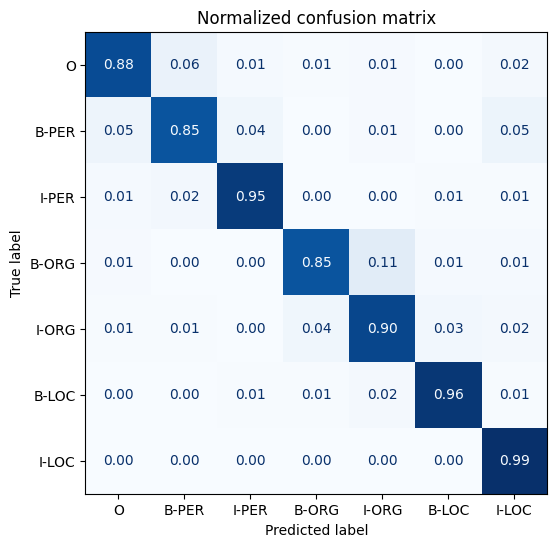

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


# The plot shows the model often confuses B-ORG and I-ORG entities, but performs
# well with other entities, as indicated by the near-diagonal confusion matrix
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)